In [1]:
import scipy.io
import os
import shutil
try:
    from urllib import urlretrieve # python2
except:
    from urllib.request import urlretrieve # python3
from train_objectives import SAD, SID

In [2]:
import data as data
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch
device = T.device("cuda")  # apply to Tensor or Module
import time
from tqdm import tqdm
torch.cuda.empty_cache()
import data

In [3]:
mat = scipy.io.loadmat( 'PaviaU.mat' )
img = mat[ 'paviaU' ]

# create a hyperspectral dataset object from the numpy array
hypData = data.HypImg( img )

# pre-process data to make the model easier to train
hypData.pre_process( 'minmax' )

In [4]:
# create data iterator objects for training and validation using the pre-processed data
trainSamples = 200000
valSamples = 100
train_data1=torch.tensor(hypData.spectraPrep[:trainSamples, :].astype(np.float32)).unsqueeze(1)
dataTrain = data.Iterator( dataSamples=train_data1,
                        targets=train_data1, batchSize=1000 )
dataVal = data.Iterator( dataSamples=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :],
                        targets=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :] )


In [5]:
trainSamples = 200000
valSamples = 100


In [6]:
# shuffle training data
dataTrain.shuffle()

In [7]:
hypData.numBands
encoderSize=[50,30,10]
encoderSize=[hypData.numBands]+encoderSize
decodersize=encoderSize[::-1]
encoderSize,decodersize

([103, 50, 30, 10], [10, 30, 50, 103])

In [8]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [9]:
# -----------------------------------------------------------

class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.enn1 = T.nn.Conv1d(1, 50,kernel_size = 3, stride = 1)  # 64-16-2-16-64
    self.enn2 = T.nn.Conv1d(50, 30,kernel_size = 3, stride = 1)
    self.enn3 = T.nn.Conv1d(30,10,kernel_size = 3, stride = 1)
    self.dnn3 = T.nn.ConvTranspose1d(10, 30,3)  # 64-16-2-16-64
    self.dnn2 = T.nn.ConvTranspose1d(30, 50,3)
    self.dnn1 = T.nn.ConvTranspose1d(50,1,3)
    self.flatten=T.nn.Flatten()
    self.dense1 = T.nn.Linear(10*97, 10)
    self.dense2 = T.nn.Linear(10,10*97)
    self.unflatten=T.nn.Unflatten(1,[10,97])
  def encoder(self,x):
    z= T.relu(self.enn1(x))
    z= T.relu(self.enn2(z))
    z= T.relu(self.enn3(z))
    z= self.flatten(z)
    z= T.relu(self.dense1(z))
    return z
  
  def decoder(self,x):
    z= T.relu(self.dense2(x))
    z= self.unflatten(z)
    z= T.relu(self.dnn3(z))
    z= T.relu(self.dnn2(z))
    z= self.dnn1(z)
    return z


  def forward(self, x):
    z=self.encoder(x)
    z= self.decoder(z)
    
    return z
net=Net().to(device)
inpu=torch.rand(50,1,103).to(device)
print(inpu.shape)
outp=net(inpu)
outp.shape


torch.Size([50, 1, 103])


torch.Size([50, 1, 103])

In [10]:
train_data = torch.tensor(dataTrain.dataSamples)
train_data

C:\Users\naras\AppData\Local\Temp\ipykernel_27884\3915235939.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(dataTrain.dataSamples)


tensor([[[1.6212e-01, 1.9130e-01, 2.0277e-01,  ..., 7.3219e-01,
          7.3266e-01, 7.4606e-01]],

        [[3.2113e-07, 5.5877e-02, 6.7117e-02,  ..., 6.5414e-01,
          6.5446e-01, 6.5735e-01]],

        [[7.3584e-07, 1.1773e-01, 1.8322e-01,  ..., 3.5688e-01,
          3.3701e-01, 3.4805e-01]],

        ...,

        [[6.0700e-02, 5.1440e-07, 9.8252e-02,  ..., 4.7634e-01,
          4.7068e-01, 4.6039e-01]],

        [[2.0342e-01, 7.4535e-02, 7.2206e-02,  ..., 3.0823e-01,
          2.8572e-01, 2.8028e-01]],

        [[2.2833e-01, 2.2989e-01, 1.3182e-01,  ..., 7.7952e-01,
          7.7403e-01, 7.9718e-01]]])

In [11]:


force_cudnn_initialization()
# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

bat_size = 3*8184
train_ldr = T.utils.data.DataLoader(train_data,
batch_size=bat_size, shuffle=True)
  # 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 1800
ep_log_interval = 5
lrn_rate = 0.0001

loss_func1 = T.nn.MSELoss()
loss_func = SAD()
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()


for epoch in range(0, max_epochs):
  
  loop= tqdm(enumerate(train_ldr), total=len(train_ldr),leave=True)
  epoch_loss = 0  # for one full epoch
  mseloss=0
  for (batch_idx, batch) in loop:
    X = batch.to(device)  # no targets needed

    optimizer.zero_grad()
    oupt = net(X)
    loss_obj = loss_func(oupt, X)  # note: X not Y
    loss_obj1=loss_func1(oupt,X)
    sum_loss=torch.sum(loss_obj.squeeze(1))
    epoch_loss += sum_loss.item()  # accumulate
    mseloss+=loss_obj1.item()
    sum_loss.backward()
    optimizer.step()
    
    loop.set_description(f"Epoch [{epoch}/{max_epochs}]")
    loop.set_postfix(loss=str(epoch_loss),mseloss=str(mseloss))

    

  #if epoch % ep_log_interval == 0:
    
    
    #print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss)) 
print("Done ")

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()


    
    
    #print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss)) 
print("Done ")

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()







Begin UCI digits auto-reduce-viz demo job 

Creating 64-16-2-16-63 autoencoder 

bat_size = 24552 
loss = SAD()
optimizer = Adam
max_epochs = 1800 
lrn_rate = 0.000 

Starting training


Epoch [67/1800]: 100%|███████████████| 9/9 [00:01<00:00,  6.67it/s, loss=35914.049072265625, mseloss=33.02719187736511]


Epoch [135/1800]: 100%|██████████████| 9/9 [00:01<00:00,  6.69it/s, loss=18347.09912109375, mseloss=12.693726658821106]


Epoch [203/1800]: 100%|██████████████| 9/9 [00:01<00:00,  6.44it/s, loss=16075.186737060547, mseloss=9.012137293815613]


Epoch [271/1800]: 100%|███████████████| 9/9 [00:01<00:00,  6.56it/s, loss=14678.34228515625, mseloss=6.174265801906586]


Epoch [339/1800]: 100%|██████████████| 9/9 [00:01<00:00,  6.70it/s, loss=13938.291625976562, mseloss=4.411265671253204]


Epoch [407/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.65it/s, loss=13355.067367553711, mseloss=3.7141736447811127]


Epoch [475/1800]: 100%|███████████████| 9/9 [00:01<00:00,  6.61it/s, loss=13135.13851928711, mseloss=3.760405659675598]


Epoch [543/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.62it/s, loss=12569.618408203125, mseloss=3.4279915392398834]


Epoch [611/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.48it/s, loss=12388.854705810547, mseloss=3.2004716396331787]


Epoch [679/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.44it/s, loss=11999.092010498047, mseloss=3.0542394816875458]


Epoch [747/1800]: 100%|██████████████| 9/9 [00:01<00:00,  6.71it/s, loss=12069.397583007812, mseloss=3.350166469812393]


Epoch [815/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.76it/s, loss=11634.677795410156, mseloss=3.1045582592487335]


Epoch [883/1800]: 100%|██████████████| 9/9 [00:01<00:00,  6.70it/s, loss=11492.588577270508, mseloss=3.583912283182144]


Epoch [951/1800]: 100%|███████████████| 9/9 [00:01<00:00,  6.48it/s, loss=11378.353393554688, mseloss=3.25030317902565]


Epoch [1019/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.62it/s, loss=11326.342681884766, mseloss=3.420035421848297]


Epoch [1087/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.71it/s, loss=11348.610137939453, mseloss=3.820436418056488]


Epoch [1155/1800]: 100%|████████████| 9/9 [00:01<00:00,  6.47it/s, loss=11151.923645019531, mseloss=3.5681853890419006]


Epoch [1223/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.71it/s, loss=11106.263107299805, mseloss=4.081655263900757]


Epoch [1291/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.69it/s, loss=11089.385345458984, mseloss=4.169507592916489]


Epoch [1359/1800]: 100%|████████████| 9/9 [00:01<00:00,  6.70it/s, loss=11028.177474975586, mseloss=4.2890181839466095]


Epoch [1427/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.54it/s, loss=10961.315032958984, mseloss=4.384009212255478]


Epoch [1495/1800]: 100%|██████████████| 9/9 [00:01<00:00,  6.72it/s, loss=11014.436248779297, mseloss=4.55725958943367]


Epoch [1563/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.77it/s, loss=11047.963104248047, mseloss=4.793186724185944]


Epoch [1631/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.40it/s, loss=10899.217086791992, mseloss=4.623312592506409]


Epoch [1699/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.54it/s, loss=10926.866195678711, mseloss=4.729821085929871]


Epoch [1767/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.57it/s, loss=10906.607025146484, mseloss=4.827102959156036]


Epoch [1799/1800]: 100%|█████████████| 9/9 [00:01<00:00,  6.28it/s, loss=10782.053924560547, mseloss=5.150498688220978]

Done 

Creating graph from encoded data 
Done 

Creating graph from encoded data 


In [12]:
loss_obj.shape()

TypeError: 'torch.Size' object is not callable

In [13]:

torch.save(net, 'model_conv_sad.pth')

In [14]:
torch.save(net.state_dict(), 'net_model_conv_sad.pth')

In [15]:
net.load_state_dict(torch.load('net_model_conv_sad.pth'))

<All keys matched successfully>

In [16]:
trex=torch.tensor(hypData.spectraPrep.astype(np.float32))
#rex = trex.shape[0],1
trex = trex.reshape(207400,1,103)
trex.shape

torch.Size([207400, 1, 103])

In [17]:
dataZ=net.encoder(trex.to("cuda"))
dataZ.shape

RuntimeError: CUDA out of memory. Tried to allocate 3.90 GiB (GPU 0; 8.00 GiB total capacity; 3.99 GiB already allocated; 1.43 GiB free; 4.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [18]:
mini_batch=10000
sendin=torch.empty(0,10).to("cuda")
sendout=torch.empty(0,1,103).to("cuda")
with torch.no_grad():
    net.eval()
    
    for i in range(0,trex.shape[0],mini_batch):
        
        boo=trex[i:i+mini_batch]
        dataZ=net.encoder(boo.to("cuda"))
        dataY = net.decoder(dataZ)
        sendin=torch.cat((sendin,dataZ))
        sendout=torch.cat((sendout,dataY))
        
print(sendout.shape,sendin.shape)

torch.Size([207400, 1, 103]) torch.Size([207400, 10])


In [19]:
trex.shape[0]

207400

In [20]:
dataZ.shape

torch.Size([7400, 10])

In [21]:
boo.shape

torch.Size([7400, 1, 103])

In [22]:
kaka=torch.empty(128,10,97).to("cuda")
with torch.no_grad():
    net.eval()
    
    for i in range(0,trex.shape[0],128):
        boo=trex[i:i+128]
        dataZ=net.encoder(boo.to("cuda"))
        kaka=torch.cat([kaka,dataZ])
kaka

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [23]:
dataY = net.decoder(dataZ)
dataY.shape

torch.Size([128, 1, 103])

In [24]:
sendout.reshape(sendout.shape[0],sendout.shape[2]).shape

torch.Size([207400, 103])

In [25]:
hypData.numRows

610

In [26]:
sendout.squeeze(1).shape

torch.Size([207400, 103])

In [27]:
imgZ = np.reshape(sendin.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [28]:
imgY = np.reshape(sendout.squeeze(1).to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [29]:
imgX = np.reshape(hypData.spectraPrep, (hypData.numRows, hypData.numCols, -1))

In [30]:
hypData.spectraPrep.shape

(207400, 103)

In [31]:
# visualise latent image using 3 out of the 10 dimensions
colourImg = imgZ.copy()
colourImg = colourImg[ :,:,np.argsort(-np.std(np.std(colourImg, axis=0), axis=0))[:3] ]
colourImg /= np.max(np.max(colourImg, axis=0), axis=0)

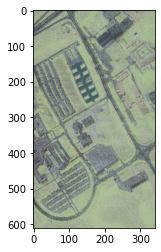

In [32]:
plt.imshow(colourImg)

Text(0.5, 1.0, 'meadow spectra')

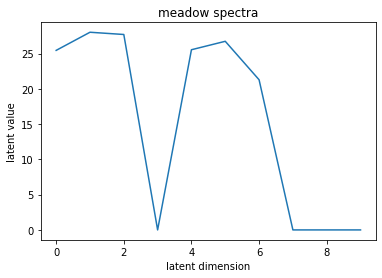

In [33]:
# save plot of latent vector of 'meadow' spectra
fig = plt.figure()
plt.plot(imgZ[576, 210, :])
plt.xlabel('latent dimension')
plt.ylabel('latent value')
plt.title('meadow spectra')

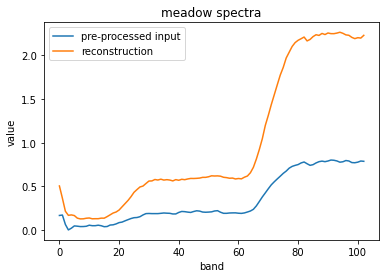

In [34]:
# save plot comparing pre-processed 'meadow' spectra input with decoder reconstruction
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(hypData.numBands),imgX[576, 210, :],label='pre-processed input')
ax.plot(range(hypData.numBands),imgY[576, 210, :],label='reconstruction')
plt.xlabel('band')
plt.ylabel('value')
plt.title('meadow spectra')
ax.legend()

In [35]:
 #--------- visualisation ----------------------------------------

 # download dataset ground truth pixel labels (if already downloaded, comment this out).
 urlretrieve( 'http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat',
                         os.path.join(os.getcwd(), 'PaviaU_gt.mat') )

('C:\\Users\\naras\\Model_train\\Conv1-Autoenc\\PaviaU_gt.mat',
 <http.client.HTTPMessage at 0x19c93cd3b50>)

In [36]:
# read labels into numpy array
mat_gt = scipy.io.loadmat( 'PaviaU_gt.mat' )
img_gt = mat_gt['paviaU_gt']
gt = np.reshape( img_gt , ( -1 ) )
gt

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [37]:
dataZ.detach()

tensor([[25.5532, 26.6411, 23.0804,  ...,  0.0000,  0.0000,  0.0000],
        [25.4979, 26.6054, 23.6016,  ...,  0.0000,  0.0000,  0.0000],
        [25.3123, 26.5414, 23.8131,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [24.6830, 26.8965, 25.5898,  ...,  0.0000,  0.0000,  0.0000],
        [24.6195, 26.0447, 24.4480,  ...,  0.0000,  0.0000,  0.0000],
        [26.0094, 27.3585, 25.6476,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [38]:
imz=imgZ
imz = imz[:,:,0]
imz=imz.reshape(-1)
imz.shape

(207400,)

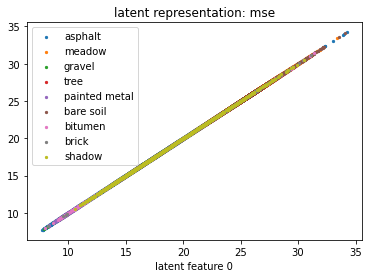

In [39]:
dataZ_collection = [imz]

for j,dataZ in enumerate(dataZ_collection):
    # save a scatter plot image of 2 of 3 latent dimensions
    std_dZ = -np.std(imz,axis=0)
    idx = np.argsort(std_dZ)
    fig, ax = plt.subplots()
    for i,gt_class in enumerate(['asphalt', 'meadow', 'gravel','tree','painted metal','bare soil','bitumen','brick','shadow']):
     ax.scatter(imz[gt == i+1], imz[gt == i+1], c='C%i'%i,s=5,label=gt_class)
    ax.legend()
    plt.title('latent representation: mse')
    plt.xlabel('latent feature %i' % (idx[0]))
#    plt.ylabel('latent feature %i' % (idx[1]))

In [40]:
from math import log10, sqrt
import numpy as np
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
def main():
     original = imgX[576, 210, :]
     compressed = imgY[576, 210, :]
     value = PSNR(original, compressed)
     print(f"PSNR value is {value} dB")
       
if __name__ == "__main__":
    main()

PSNR value is 49.784608062943676 dB


In [41]:
psnr=[]
import statistics
for i in range(hypData.numBands):
    original = imgX[:, :, i]
    compressed = imgY[:, :, i]
    value = PSNR(original, compressed)
    psnr.append(value)
    

print(f" Mean PSNR value is {statistics.mean(psnr)} dB")

 Mean PSNR value is 52.634651310357754 dB


In [42]:
from skimage.metrics import structural_similarity
##skimage.metrics.
import argparse
import imutils
import cv2

ssim_score=[]
import statistics
for i in range(hypData.numBands):
    # 3. Load the two input images
    imageA = imgX[:, :, i]
    imageB = imgY[:, :, i]

    # 4. Convert the images to grayscale
    #grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    #grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)


    # 5. Compute the Structural Similarity Index (SSIM) between the two
    #    images, ensuring that the difference image is returned
    (score, diff) = structural_similarity(imageA, imageB, full=True)
    diff = (diff * 255).astype("uint8")
    ssim_score.append(score)

# 6. You can print only the score if you want
print("SSIM: {}".format(score))
print(f"Mean SSIM {statistics.mean(ssim_score)} dB")




D:\Anaconda\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


SSIM: 0.40599831201704406
Mean SSIM 0.3954357825224721 dB


In [43]:
tensory=torch.Tensor(imgY)
tensorx=torch.Tensor(imgX)

In [44]:
import metrics 

print(f"CC: {metrics.cross_correlation(tensorx.cpu(),tensory.cpu())}")
print(f"SAM: {metrics.SAM(tensorx.cpu(),tensory.cpu())}")

print(f"RMSE: {metrics.RMSE(tensorx.cpu(),tensory.cpu())}")
print(f"PSNR: {metrics.PSNR2(tensorx.cpu(),tensory.cpu()) }")


CC: 0.995347797870636
SAM: 3.442261219024658
RMSE: 0.7734813690185547
PSNR: 11.708992958068848
